# Model Analysis


## 1. Introduction

We now have some cleaned ML data, and a model trained on this data which can make some predictions.

This notebook will present the results - i.e. the predicted skin temperature - of this trained model, and compare with the observations and the ERA "predictions". 


### 1.1 Quick review 

The steps we took to get to this point are (see also `00. Summary.ipynb`):

1. Convert monthly ERA `.grib` files into hourly `NetCDF`, converting the longtiude to `long1` format in the process.

2. Join the ERA data with the MODIS data to produce a collection of hourly `.pkl` files.

3. Merge all hourly joined files into a single "cleaned ML data" source.

4. Train a NN on a subset of this data source - just 2018. Predictions are made on 2020. 2019 is left as a buffer or if we need a validation set.

---

### 1.2 Other useful info


The features used when training the model are as follows:


In [15]:

feature_names = [ 'sp', 'msl', 'u10', 'v10','t2m',
                  'aluvp', 'aluvd', 'alnip', 'alnid', 'cl',
                  'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor', 'slor',
                  'd2m', 'lsm', 'fal','skt'] 
import requests
import pandas as pd

r = requests.get("https://apps.ecmwf.int/codes/grib/json/").json()['parameters']

def param_name(x,r):
    try:
        d = next(item for item in r if item["param_shortName"] == x)
        name = d['param_name']
        units = d['units_name']
    except:
        #maybe naming convention is different
        name = 'Null'
        units = 'Null'
    
    return f'{x}: {name} : {units}'


for i in feature_names:
    print(param_name(i,r))

sp: Wind speed (SP) : m s**-1
msl: Mean sea level pressure : Pa
u10: Null : Null
v10: Null : Null
t2m: Null : Null
aluvp: UV visible albedo for direct radiation : (0 - 1)
aluvd: UV visible albedo for diffuse radiation : (0 - 1)
alnip: Near IR albedo for direct radiation : (0 - 1)
alnid: Near IR albedo for diffuse radiation : (0 - 1)
cl: Lake cover : (0 - 1)
cvl: Low vegetation cover : (0 - 1)
cvh: High vegetation cover : (0 - 1)
slt: Soil type : ~
sdfor: Standard deviation of filtered subgrid orography : m
z: Geopotential : m**2 s**-2
sd: Snow depth water equivalent : kg m**-2
sdor: Standard deviation of orography : m
isor: Anisotropy of sub-gridscale orography : ~
anor: Angle of sub-gridscale orography : radians
slor: Slope of sub-gridscale orography : ~
d2m: Null : Null
lsm: Land-sea mask : (0 - 1)
fal: Forecast albedo : (0 - 1)
skt: Skin temperature : K


---

## 2. Load the data

The predictions along with the trained model itself and the training history are in `/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ML_1648483592/`

These predictions are for all of 2020, on an hourly grain, across the entire Earth surface. 

Lets load the data, and create some extra columns to quantify the prediction errors.

We compare MODIS LST with ERA SKT and NN SKT.

In [29]:
path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ML_1649066913/' #this is a trained model WITHOUT using t2m
#path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ML_1649069995/' #this is a trained model without a bunch of params
path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ML_1649072169/' #this is a trained model without  sdor,slt

In [30]:
import pandas as pd
df = pd.read_pickle(path+'predictions.pkl')

#Create some new columns for the errors
df['error_ERA'] = df.MODIS_LST - df.skt
df['error_ERA_abs'] = abs(df.MODIS_LST - df.skt)

df['error_NN'] = df.MODIS_LST - df.predictions
df['error_NN_abs'] = abs(df.MODIS_LST - df.predictions)

#Surface some useful numbers
print('Absolute error:')
print('--------------------------------')
print("NN model: Mean error, Median error, Std deviation:",df.error_NN_abs.mean(), df.error_NN_abs.median(),df.error_NN_abs.std())
print("ERA5: Mean error, Median error, Std deviation    :", df.error_ERA_abs.mean(), df.error_ERA_abs.median(),df.error_ERA_abs.std())

print('Biased error:')
print('--------------------------------')
print("NN model: Mean bias, Median bia, Std deviation:",df.error_NN.mean(), df.error_NN.median(),df.error_NN.std())
print("ERA5: Mean bias, Median bias, Std deviation::    ", df.error_ERA.mean(), df.error_ERA.median(),df.error_ERA.std())



Absolute error:
--------------------------------
NN model: Mean error, Median error, Std deviation: 3.16429 2.4346008 2.80639
ERA5: Mean error, Median error, Std deviation    : 3.7469294 2.9239807 3.3043458
Biased error:
--------------------------------
NN model: Mean bias, Median bia, Std deviation: 0.1934183 0.36904907 4.22506
ERA5: Mean bias, Median bias, Std deviation::     -0.71137625 -0.6607971 4.944907


In [31]:
df

latitude_ERA  longitude_ERA                time         skt  \
71034945     -70.117048          45.75 2020-01-01 10:00:00  257.686279   
71034946     -70.117048          47.25 2020-01-01 10:00:00  256.631592   
71034947     -70.117048          48.00 2020-01-01 10:00:00  256.758545   
71034948     -70.117048          48.75 2020-01-01 10:00:00  256.949951   
71034949     -70.117048          49.50 2020-01-01 10:00:00  256.662842   
...                 ...            ...                 ...         ...   
105640205     70.117048          69.75 2020-12-30 09:00:00  240.706482   
105640206     70.117048          71.25 2020-12-30 09:00:00  241.774841   
105640207     70.117048          72.00 2020-12-30 09:00:00  242.374451   
105640208     70.117048          74.25 2020-12-30 09:00:00  238.112732   
105640209     70.117048          75.00 2020-12-30 09:00:00  237.513123   

                  t2m   MODIS_LST       lsm  predictions  error_ERA  \
71034945   258.250977  255.351456  1.000000   254.297943  -2.334824   
71034946   257.209961  256.923279  1.000000   253.684067   0.291687   
71034947   257.432617  256.583191  1.000000   254.044922  -0.175354   
71034948   257.778320  259.628265  1.000000   254.125137   2.678314   
71034949   257.629883  260.910400  1.000000   253.672424   4.247559   
...               ...         ...       ...          ...        ...   
105640205  241.386597  241.867874  0.990330   241.605011   1.161392   
105640206  242.644409  243.849625  0.857928   242.365555   2.074783   
105640207  243.597534  243.605469  0.906867   242.404388   1.231018   
105640208  239.439331  240.991898  0.993482   240.279419   2.879166   
105640209  239.302612  240.527832  0.989185   239.557068   3.014709   

           error_ERA_abs  error_NN  error_NN_abs  
71034945        2.334824  1.053513      1.053513  
71034946        0.291687  3.239212      3.239212  
71034947        0.175354  2.538269      2.538269  
71034948        2.678314  5.503128      5.503128  
71034949        4.247559  7.237976      7.237976  
...                  ...       ...           ...  
105640205       1.161392  0.262863      0.262863  
105640206       2.074783  1.484070      1.484070  
105640207       1.231018  1.201080      1.201080  
105640208       2.879166  0.712479      0.712479  
105640209       3.014709  0.970764      0.970764  

[34605265 rows x 12 columns]

## 3. Visualize the data

Picture = 1000 words etc. etc. Here are some plots


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt


def error_plot(df,x,grain):
    
    """
    Plotting function.
    df: data to plot
    x: What variable do you want the x-axis to be?
    grain: Precision of the x axis e.g. days. If int, then decimal precision
    relative: Boolean. Plot relative error or absolute error
    """

    
    
    
    
    #Some new columns used for plotting
    
    
    #Setup the x variable to plot.
    if x == 'time':
        df["X"] = df[x].dt.to_period(grain).dt.to_timestamp()
    else:
        df["X"] = df[x].round(grain) # Can also use .apply(lambda x: custom_round(x, base=2))
    
        
    #Group by
    df_plot = df.groupby(['X'],as_index=False).mean()
    
     #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    
    #Plot
    p = sns.lineplot(data=df_plot, x='X', y='error_NN_abs',ax=ax1,markers=True,label='NN')
    p = sns.lineplot(data=df_plot, x='X', y='error_ERA_abs',ax=ax1,markers=True,label='ERA')
    
    #Config
    ax1.set_xlabel('time', fontsize = 20)
    ax1.set_ylabel('Error [K]', fontsize = 20)


    

    #Other config
    ax1.legend().set_title(None)
    

        
import matplotlib.colors as mc
import matplotlib.colorbar as cb  
def plot_map(df,z,vmin,vmax,cmap,save):
    
    #Get all data as vectors
    x = df.longitude_ERA
    y = df.latitude_ERA
    z1 = df[z]
    
    #Scatter plot it
    # init the figure
    fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

    
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    sc = ax.scatter(x, y,
               s=1,
               c=cmap(norm(z1)),
               linewidths=1, alpha=.7
               )

    ax.set_title(z)
    
    if save is True:
        plt.savefig('example_image.png')
    plt.show()

## Error vs time

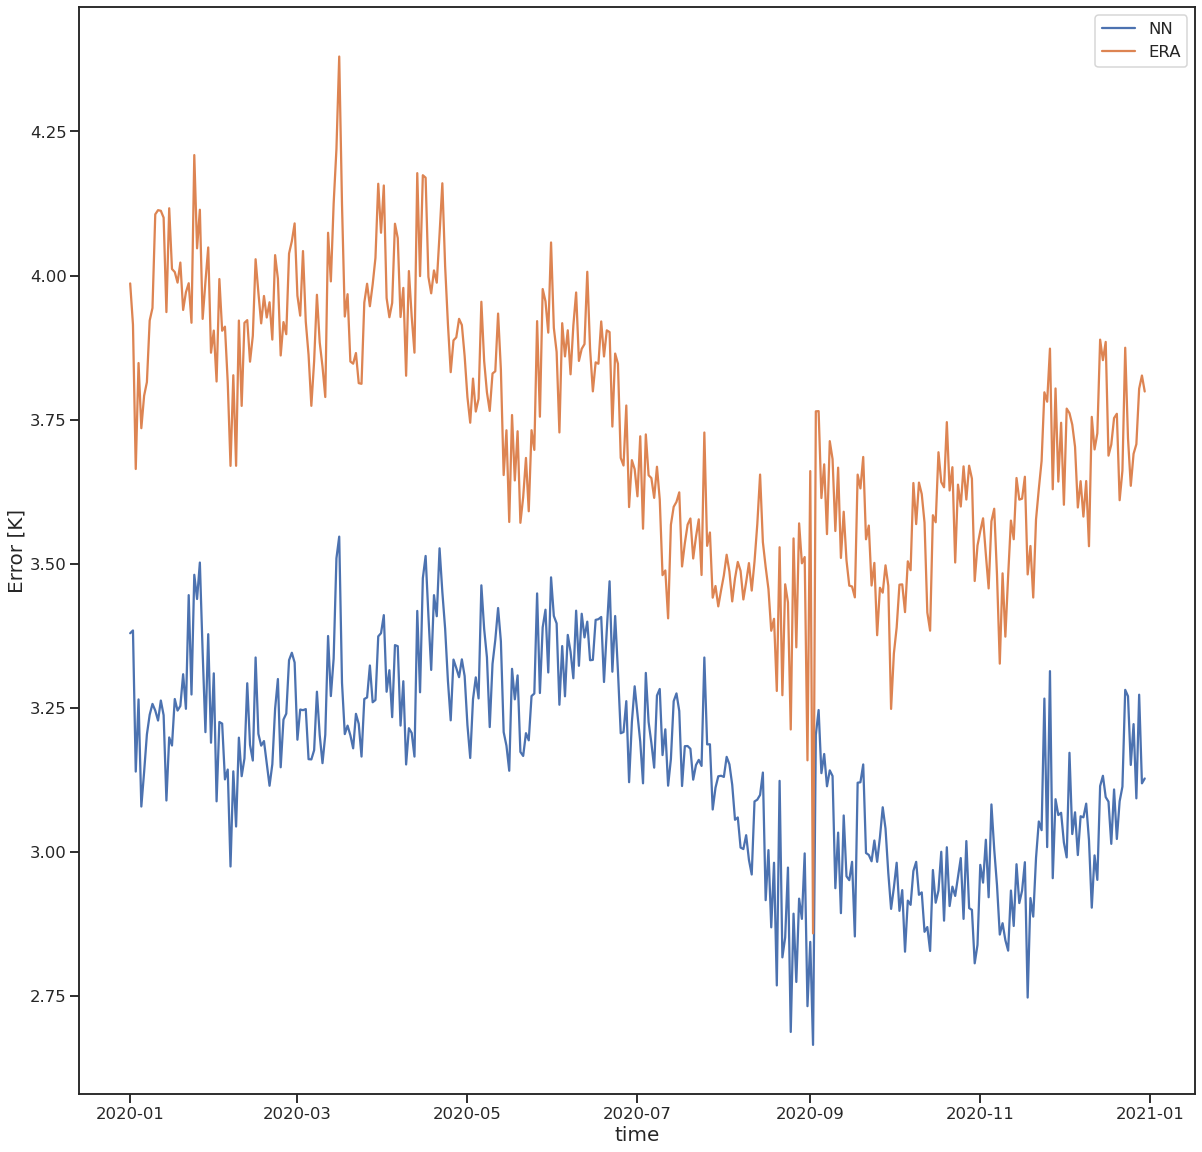

In [33]:
error_plot(df,'time','D')

## Error map

Average over time 


In [34]:
%%time
#Group by lat/long i.e. average over time
ds_map = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()


CPU times: user 12 s, sys: 2.38 s, total: 14.4 s
Wall time: 14.4 s


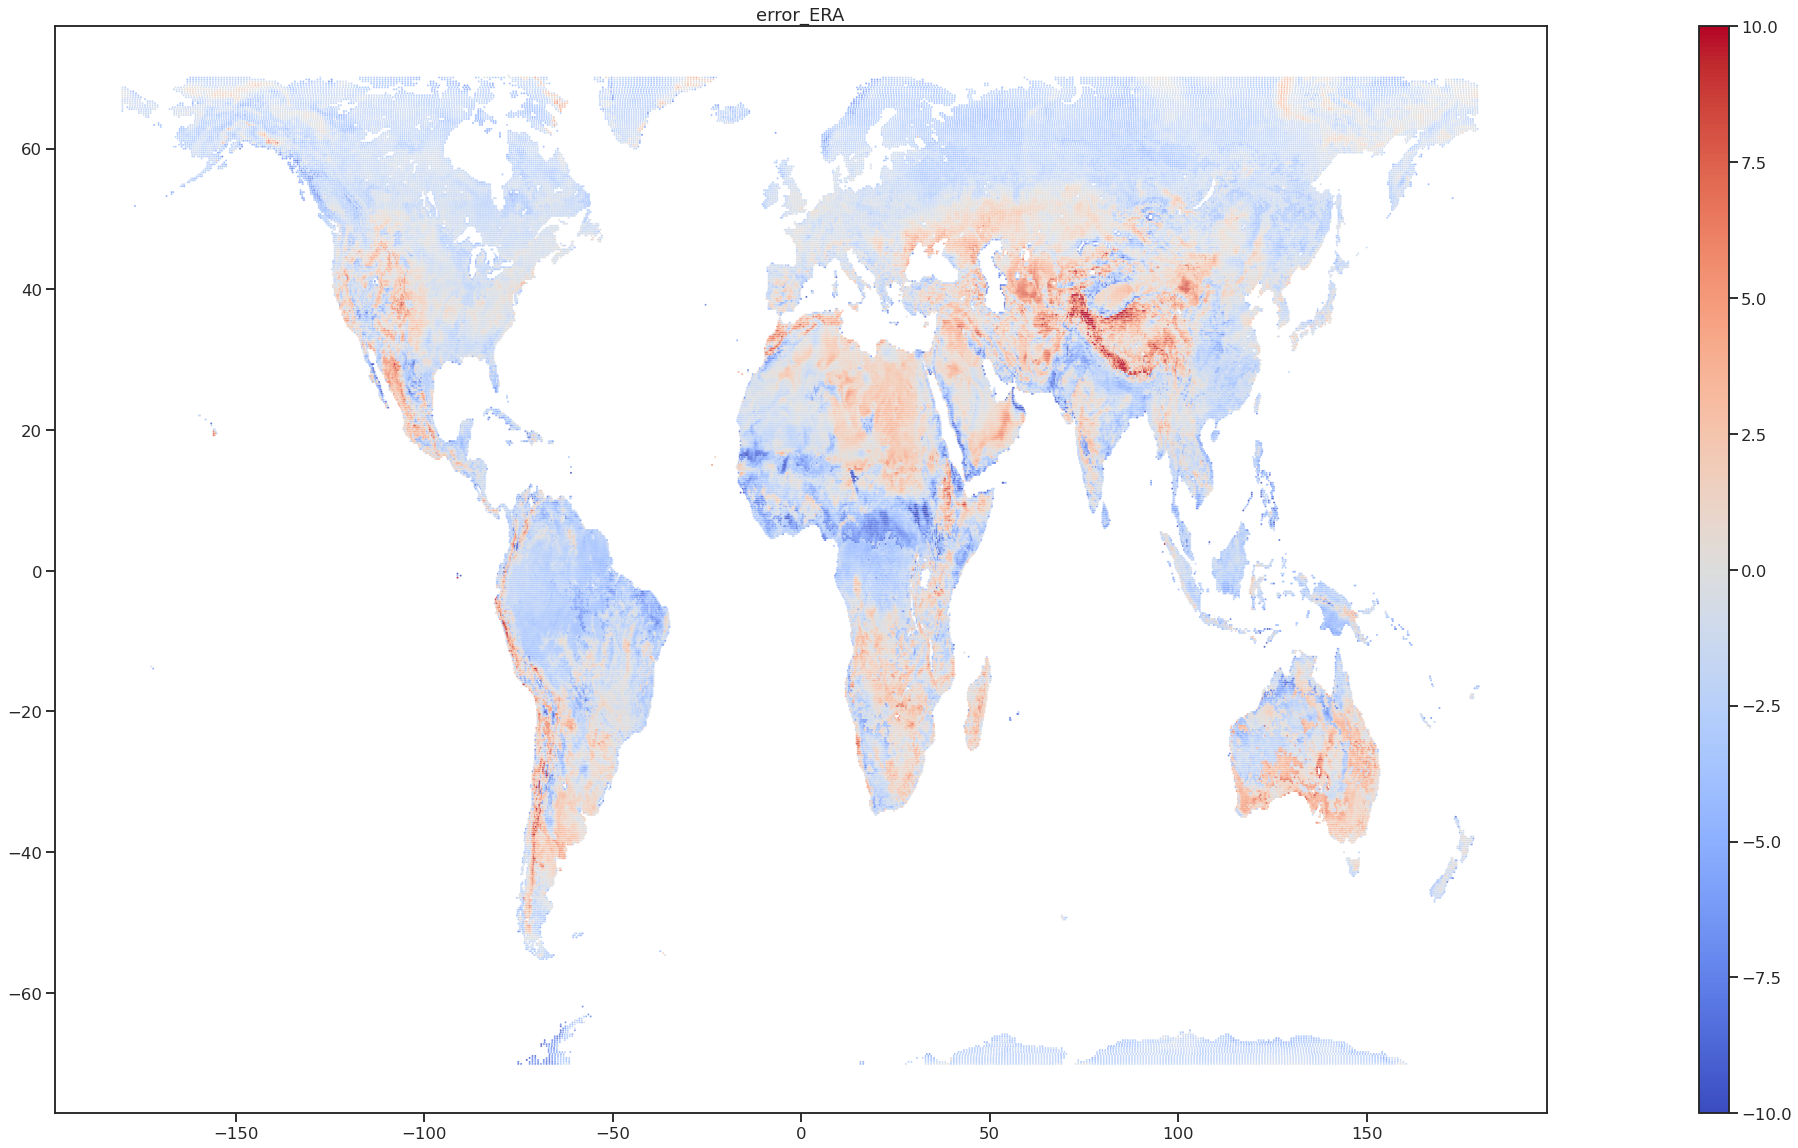

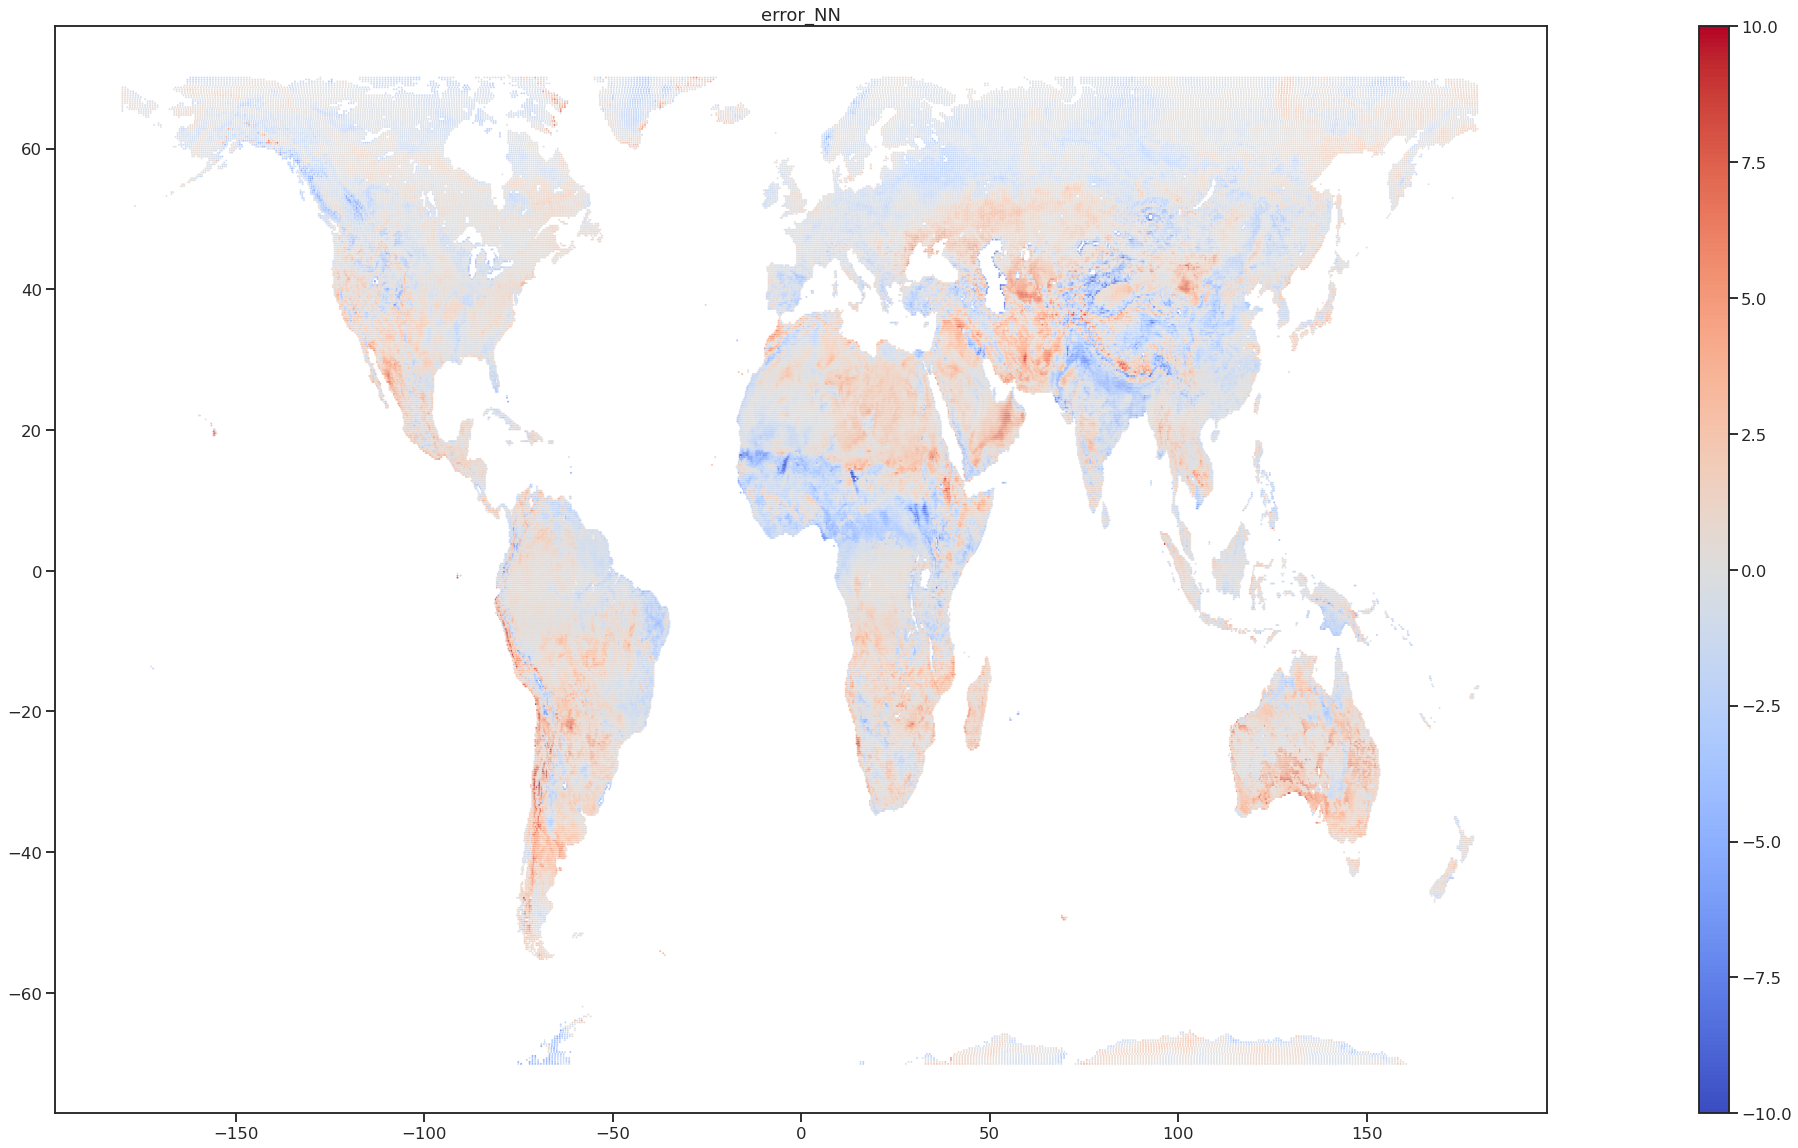

In [35]:
plot_map(ds_map,'error_ERA',vmin=-10,vmax=10,cmap = plt.cm.coolwarm,save=True)
plot_map(ds_map,'error_NN',vmin=-10,vmax=10,cmap = plt.cm.coolwarm,save=False)

We can also plot the absolute error with a sequantial cmap:

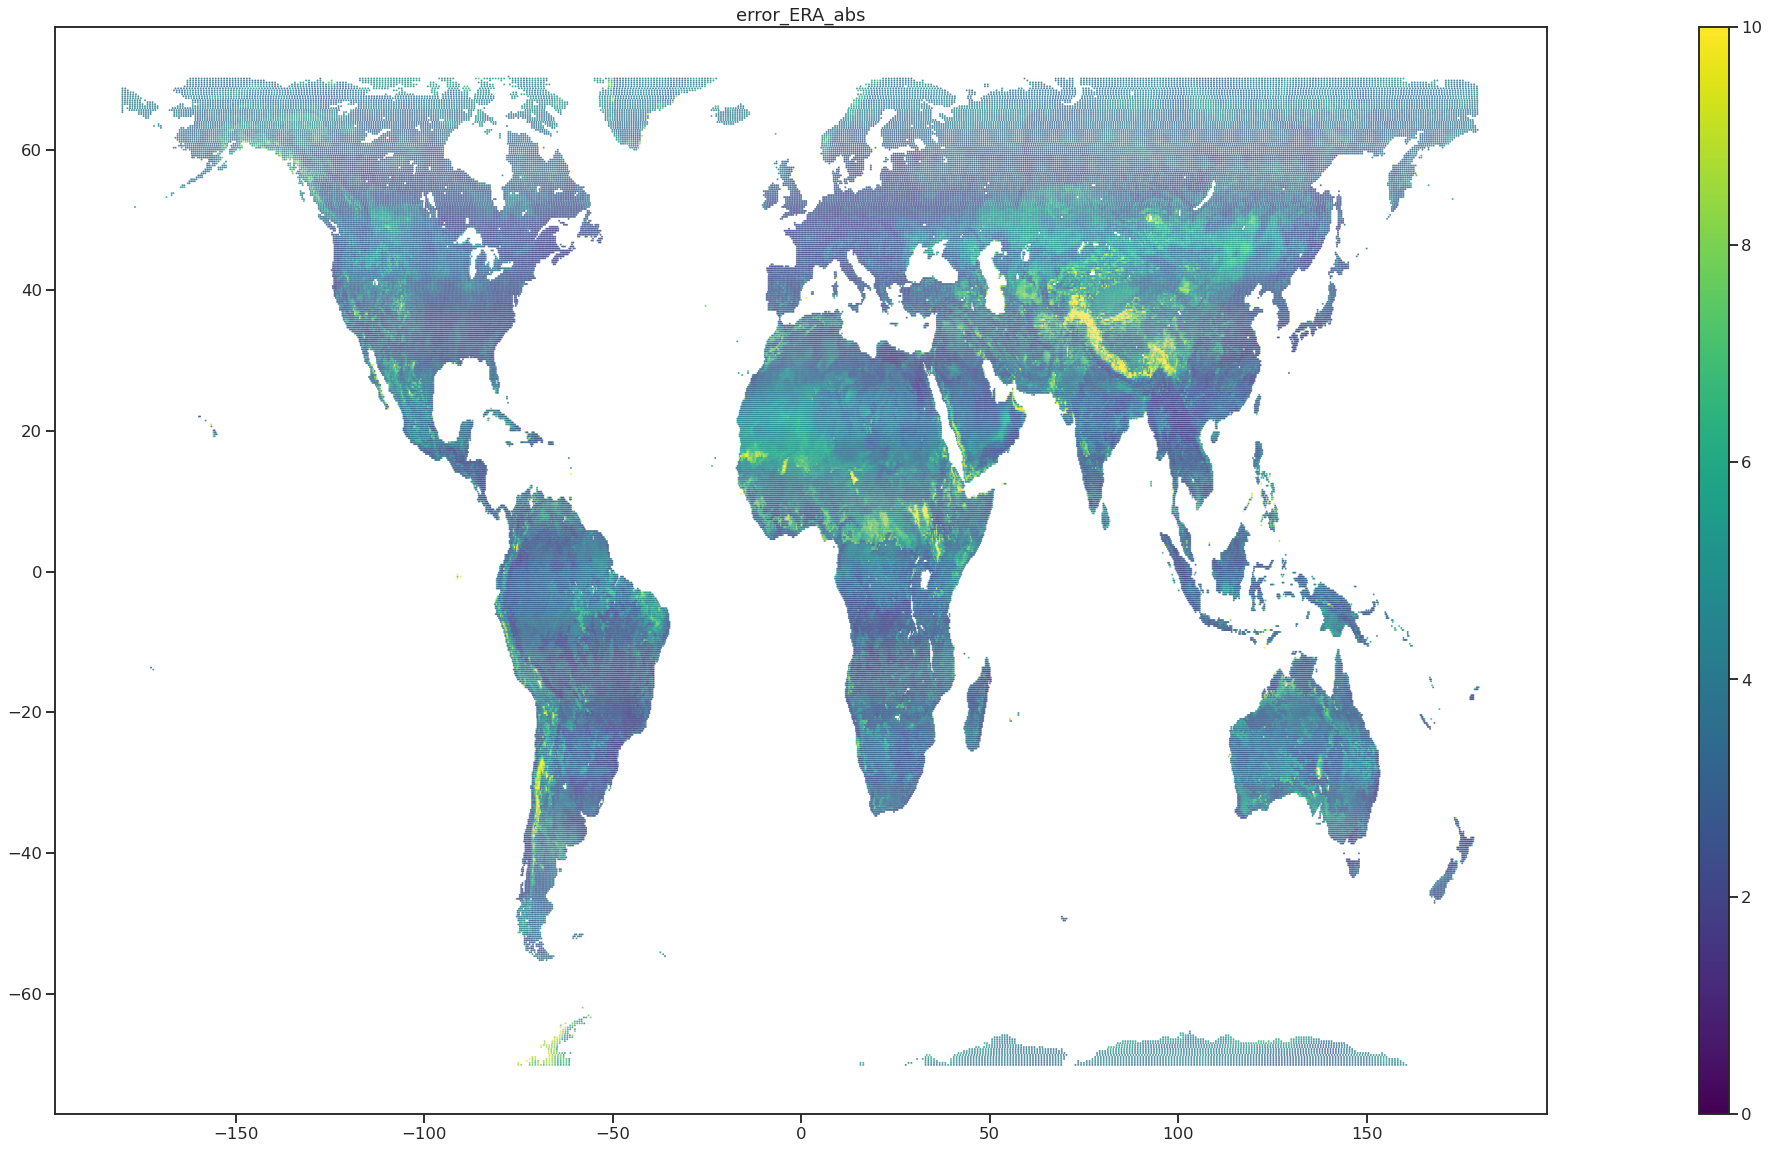

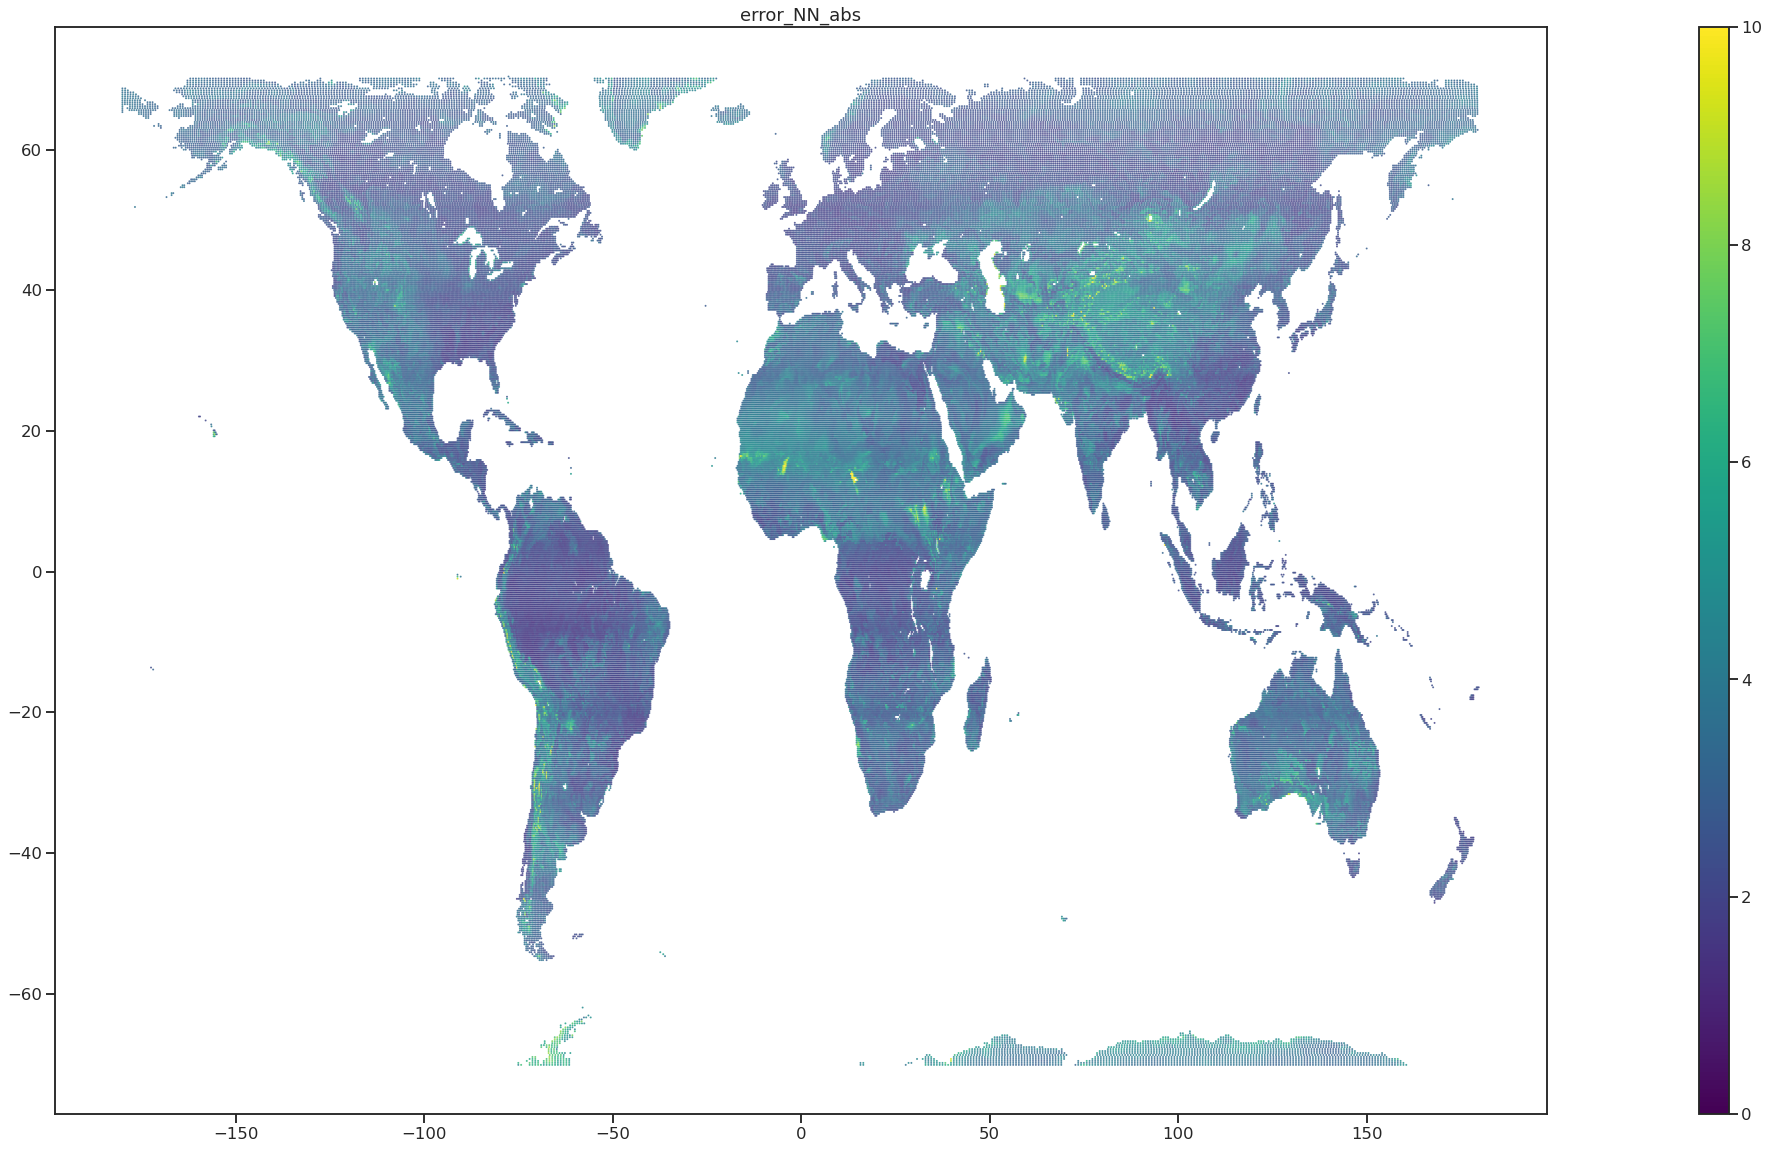

In [36]:
plot_map(ds_map,'error_ERA_abs',vmin=0,vmax=10,cmap=plt.cm.viridis,save=False)
plot_map(ds_map,'error_NN_abs',vmin=0,vmax=10,cmap=plt.cm.viridis,save=False)

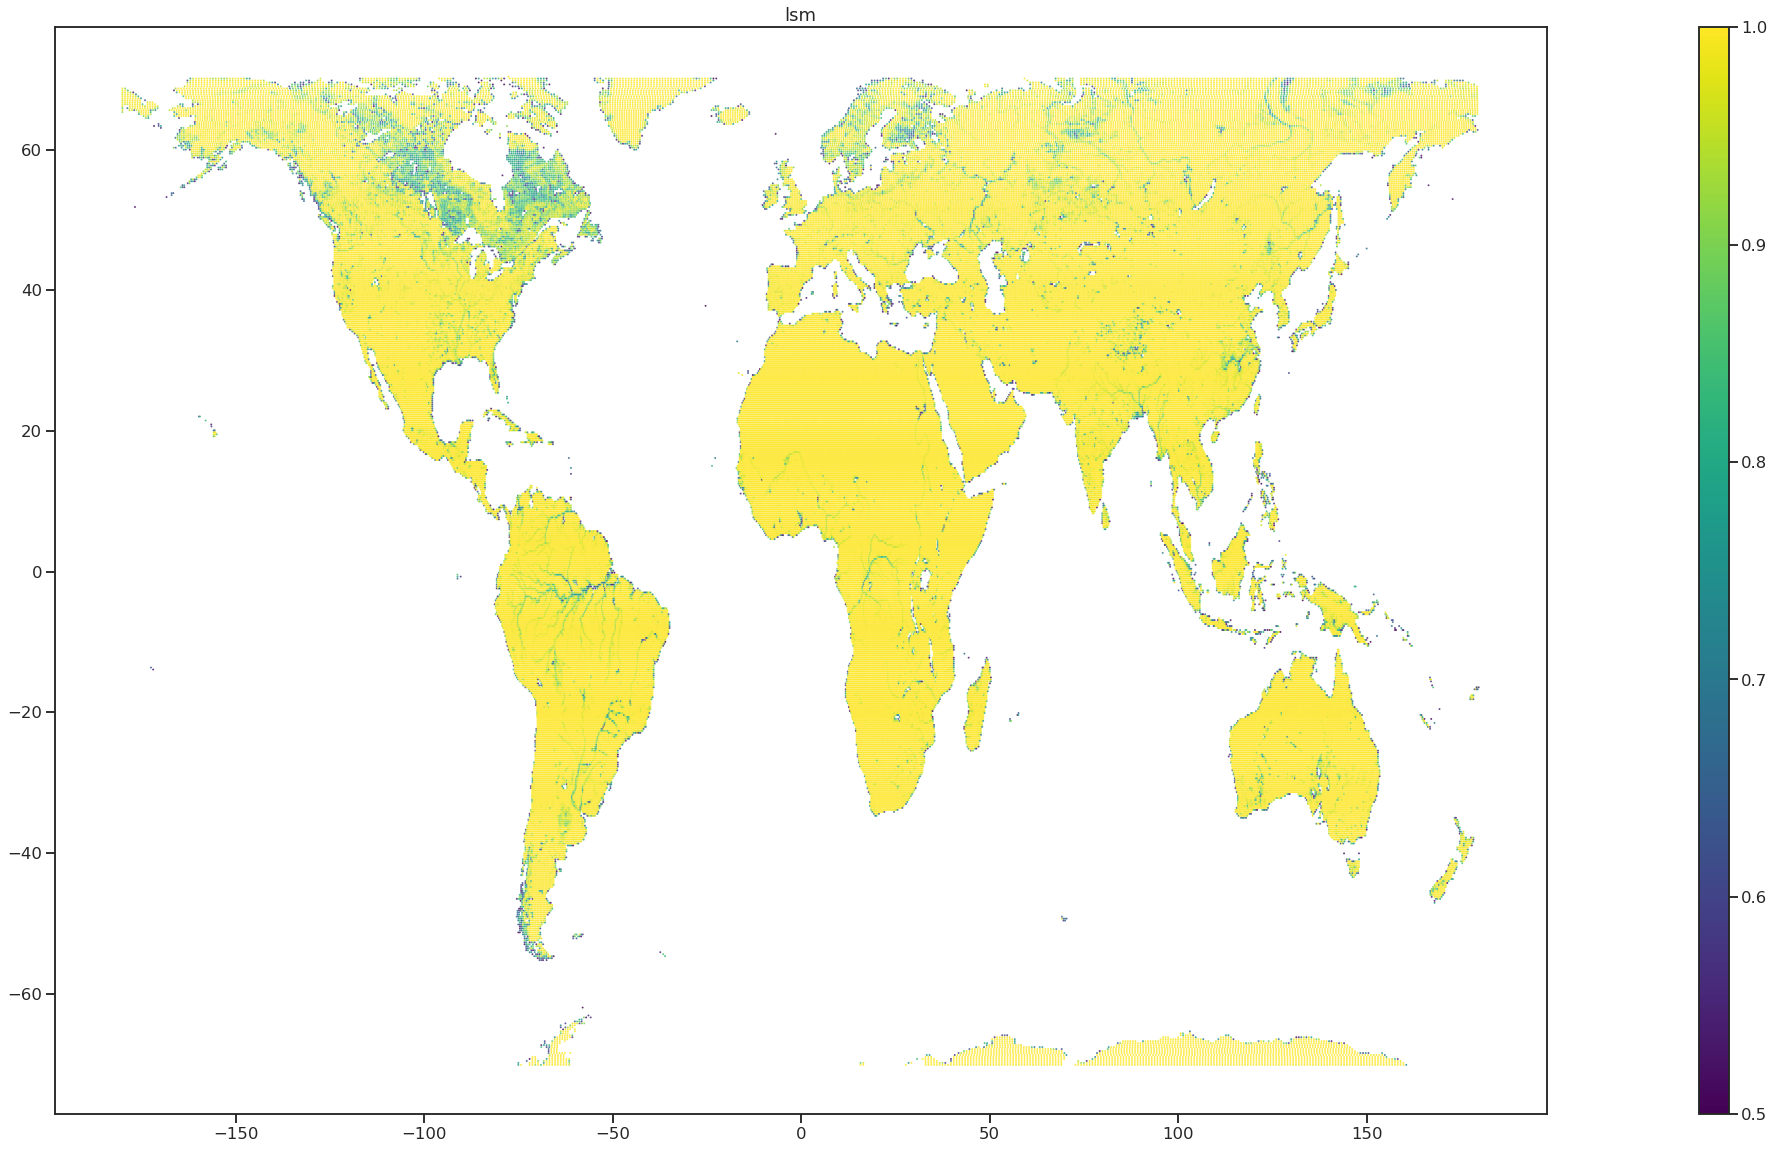

In [20]:
plot_map(ds_map,'lsm',vmin=0.5,vmax=1,cmap=plt.cm.viridis,save=False)

# Distributions

In [10]:
def plot_distribution(d,bins,absolute_values):
    
    #seaborn histplot is quite slow for some reason?
    
    
      #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    
    
    #Plot    
    p1 = sns.histplot(data=d, x="error_ERA", ax=ax1,stat='probability', bins=bins,alpha=0.7,color='C0',label='ERA')
    p2 = sns.histplot(data=d, x="error_NN", ax=ax1,stat='probability', bins=bins,alpha=0.7,color='C1',label='NN')


    

    
    # Config
    ax1.set_xlabel('Error', fontsize = 20)
    ax1.legend().set_title(None)
    
    
    ax1.axvline(0,c='0.5', linestyle='--')
    
    
    
    


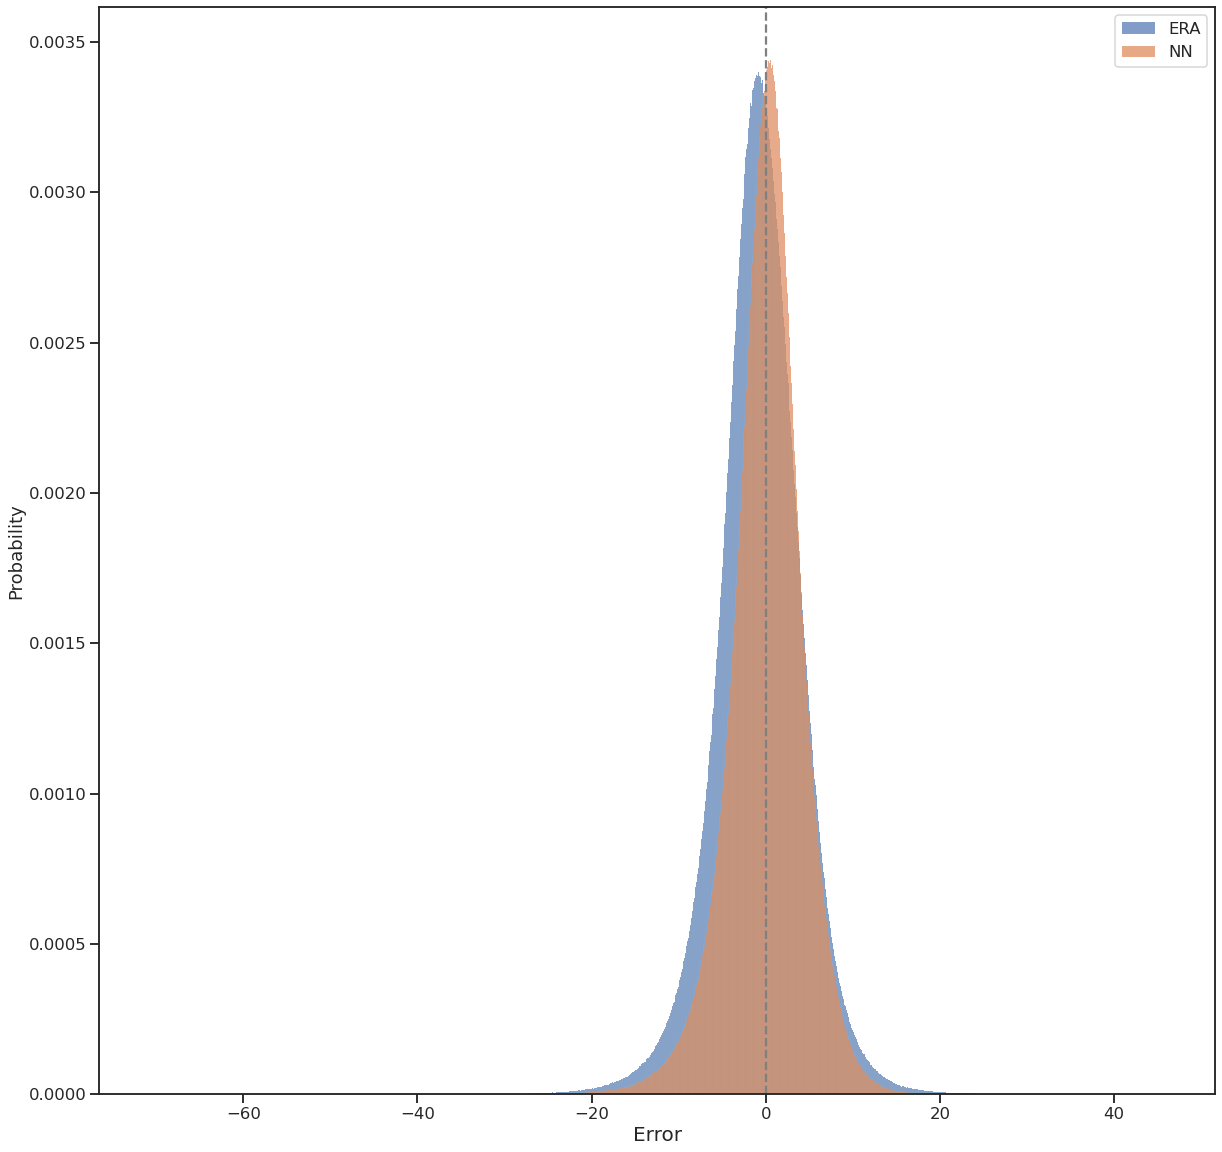

In [11]:
plot_distribution(df,bins='auto',absolute_values=False )



---


# Appendix










It is also useful to be able to take an average over a specified time period:

In [46]:
df_month = df.copy()
df_month["time_month"] = df_month['time'].dt.to_period('M').dt.to_timestamp()
ds_map_month = df_month.groupby(['latitude_ERA', 'longitude_ERA','time_month'],as_index=False).mean()




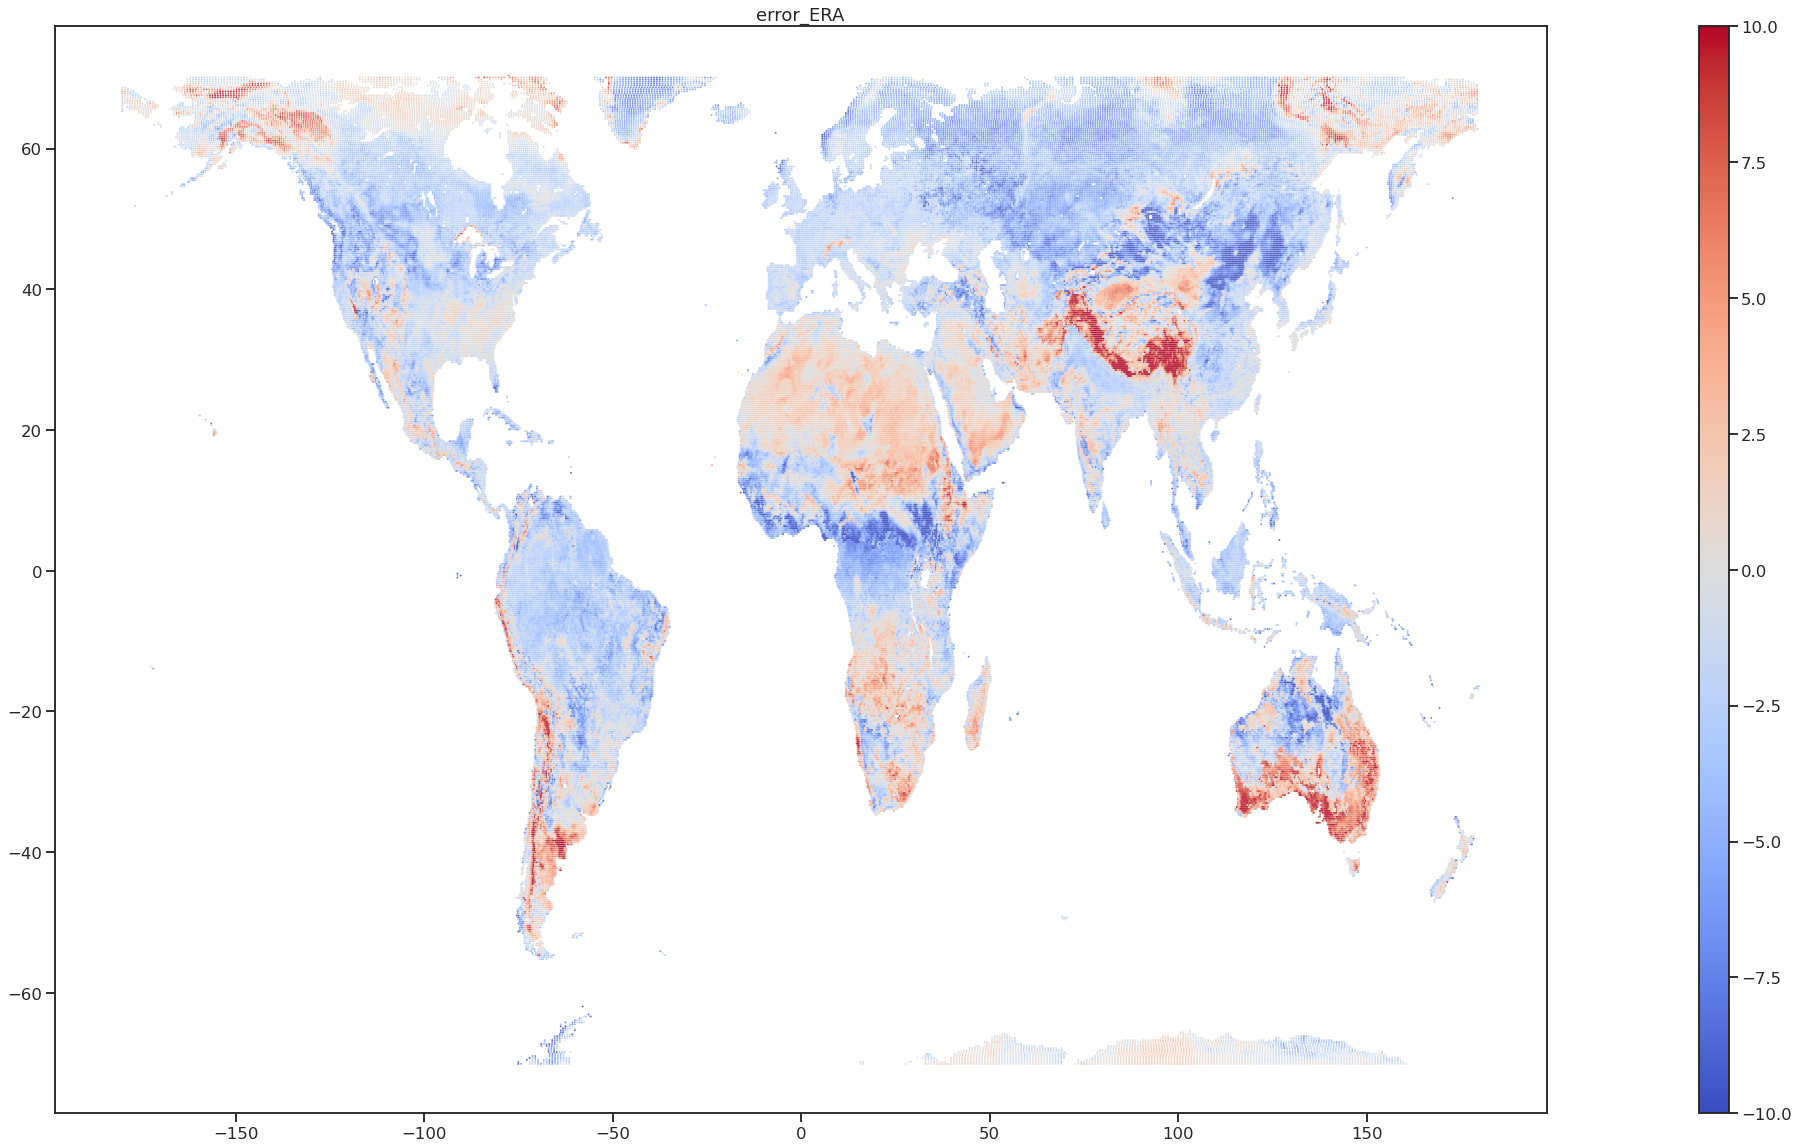

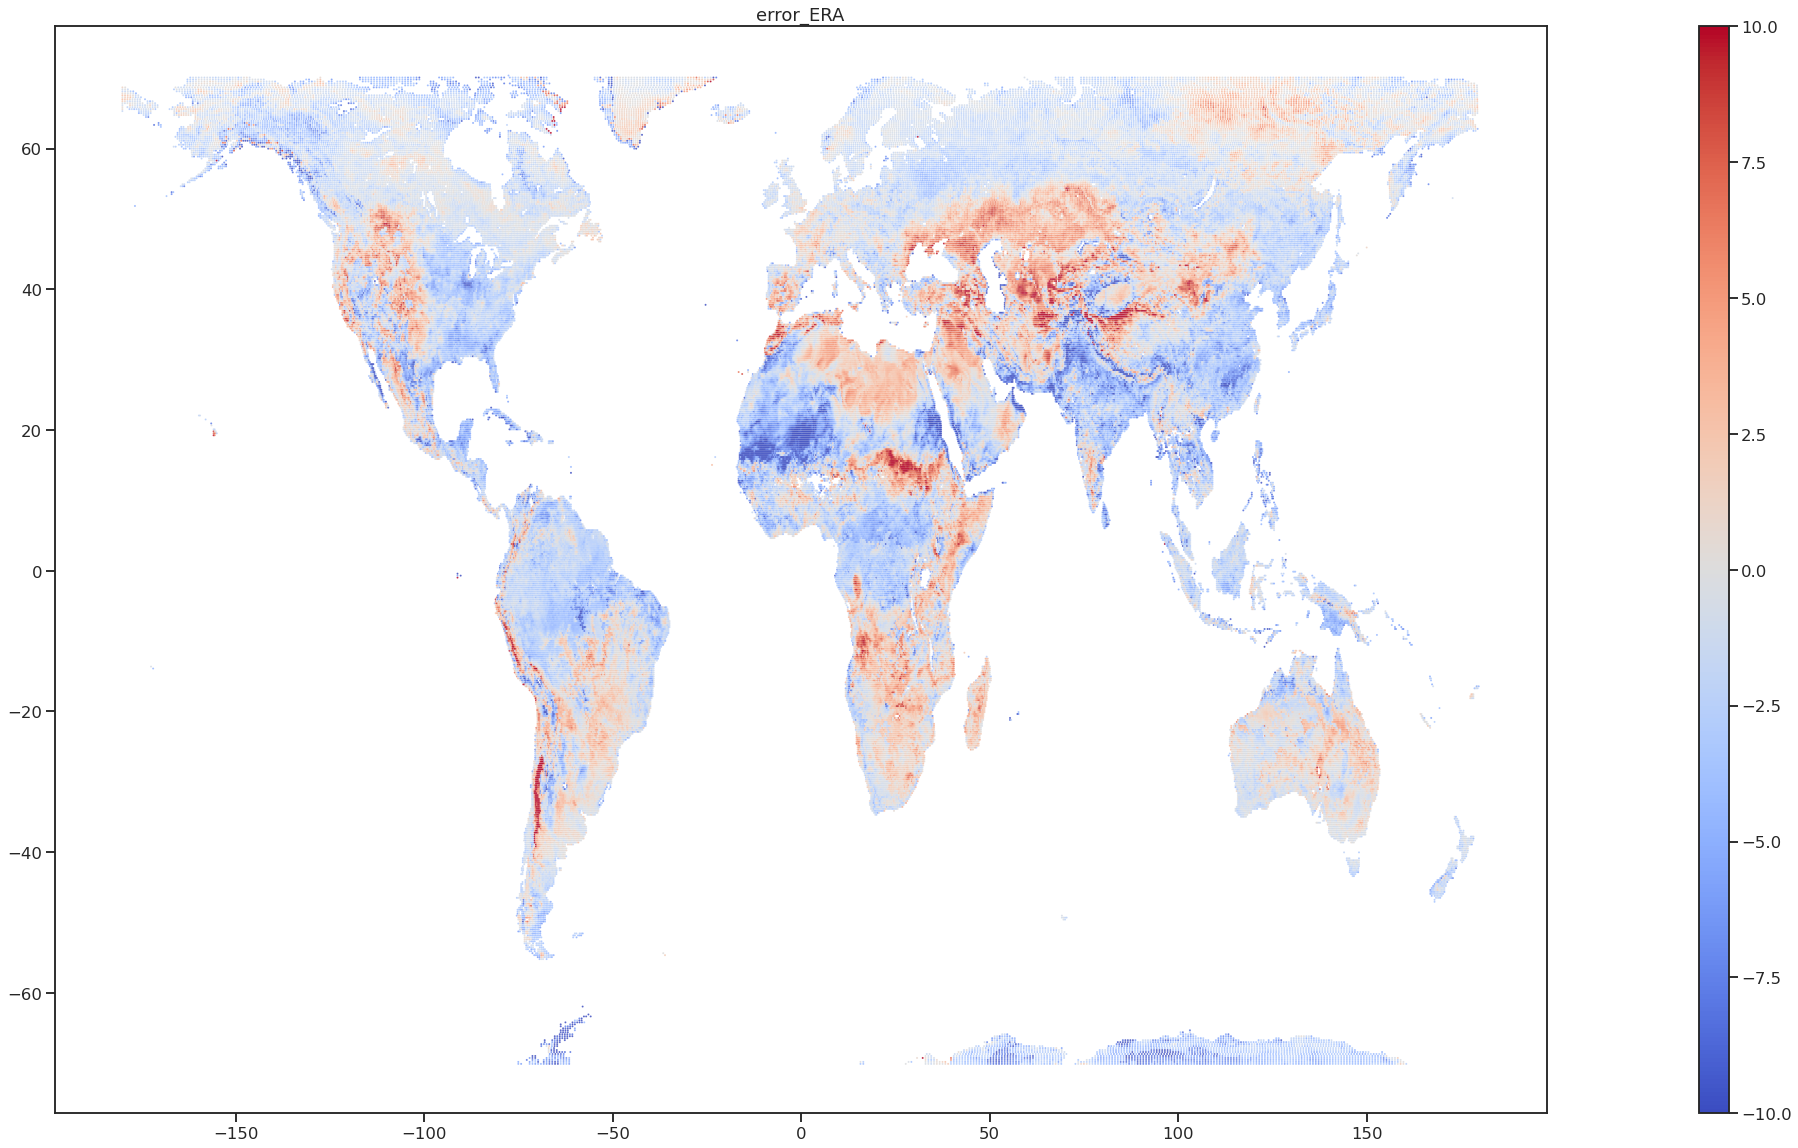

In [48]:
df_plot = ds_map_month.query('time_month == "2020-01-01"')
plot_map(df_plot,'error_ERA',vmin=-10,vmax=10,cmap = plt.cm.coolwarm,save=False)


df_plot = ds_map_month.query('time_month == "2020-08-01"')
plot_map(df_plot,'error_ERA',vmin=-10,vmax=10,cmap = plt.cm.coolwarm,save=False)

---

# Appendix


## A1 Model Training

We can also look at how the model trained:

In [ ]:
import json
with open(path+'history.json') as f:
    d = json.load(f)


In [ ]:
import numpy as np
y = d['loss']
x = np.arange(len(y))

fig = plt.figure(figsize=(20, 20))
plt.plot(x,y)
#plt.xscale('log')
#plt.yscale('log')

## A2 Time slice

In [13]:
df_tmp = df.copy()

In [14]:
df_tmp = df.copy()
df_tmp['error_ERA'] = abs(df_tmp.MODIS_LST - df_tmp.t2m)
df_tmp['error_NN'] = abs(df_tmp.MODIS_LST - df_tmp.predictions)
df_tmp['error_ERA_rel'] = abs(df_tmp.MODIS_LST - df_tmp.t2m) / df_tmp.MODIS_LST
df_tmp['error_NN_rel'] = abs(df_tmp.MODIS_LST - df_tmp.predictions) / df_tmp.MODIS_LST
df["time_daily"] = df['time'].dt.to_period('D').dt.to_timestamp()
ds_map = df_tmp.groupby(['latitude_ERA', 'longitude_ERA','time_daily'],as_index=False).mean()

KeyError: 'time_daily'

In [ ]:
all_days = np.unique(df["time_daily"])

In [ ]:
ti = all_days[3]

In [ ]:
ti

In [ ]:
%matplotlib notebook

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [ ]:
%matplotlib widget

In [ ]:
fig, ax = plt.subplots()
line, = ax.plot([])     # A tuple unpacking to unpack the only plot
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1.1, 1.1)

In [ ]:
import xarray as xr


In [ ]:
sat_xr.data.count()

In [ ]:
import numpy as np
sat_xr = xr.open_dataarray(f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/aquaDay_errorGTE03K_04km_2020-06-25.tif',engine="rasterio")
np.count_nonzero(~np.isnan(sat_xr.data)) / 1e6

In [ ]:
sat_xr

In [ ]:
import numpy as np
sat_xr = xr.open_dataarray(f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/aquaDay_errorGTE03K_04km_2020-08-25.tif',engine="rasterio")
np.count_nonzero(~np.isnan(sat_xr.data)) / 1e6

In [ ]:
sat_xr

In [ ]:
f = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib'
ds = xr.open_dataset(f,engine='cfgrib',filter_by_keys={'typeOfLevel': 'surface'})

In [ ]:
ds